# Regression with linear models
We explore the performance of several linear regression models on a real-world dataset, i.e. [MoneyBall](https://www.openml.org/d/41021). This dataset captures performance data from baseball players. The regression task is to accurately predict the number of 'runs' each player can score, and understanding which are the most important factors.

In [1]:
# General imports
%matplotlib inline
from preamble import *

In [2]:
# Download MoneyBall data from OpenML
moneyball = oml.datasets.get_dataset(41021)
# Get the predictors X and the target y. Also get the list of categorical features for later use.
X, y, categorical, attribute_names = moneyball.get_data(target=moneyball.default_target_attribute, 
                                                        return_categorical_indicator=True, 
                                                        return_attribute_names=True)

## Exploratory analysis and visualization
First, we visually explore the data by visualizing the value distribution and the interaction between every other feature in a scatter matrix. We use the target feature as the color variable to see which features are correlated with the target.

For the plotting to work, however, we need to fill in the missing values. Let's find out which columns have missing values. This matches what we already saw on the OpenML page (https://www.openml.org/d/41021).

In [3]:
# Describe the data with pandas, just to get an overview
ballframe = pd.DataFrame(X, columns=attribute_names)
# Ask pandas which columns have missing values
pd.isnull(ballframe).any()

Team            False
League          False
Year            False
RA              False
W               False
OBP             False
SLG             False
BA              False
Playoffs        False
RankSeason       True
RankPlayoffs     True
G               False
OOBP             True
OSLG             True
dtype: bool

We impute the missing values using the median. This seems more adequate than replacing them by 0. Removing all instances with missing values is not really an option since some features have consistent missing values: we would have to remove a lot of data.

In [4]:
# Impute missing values with sklearn and rebuild the dataframe
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
ballframe_clean = pd.DataFrame(imputer.fit_transform(ballframe), columns = attribute_names)

Next, we build the scatter matrix. We include the target column to see which features strongly correlate with the target, and also use the target value as the color to see which combinations of features correlate with the target.

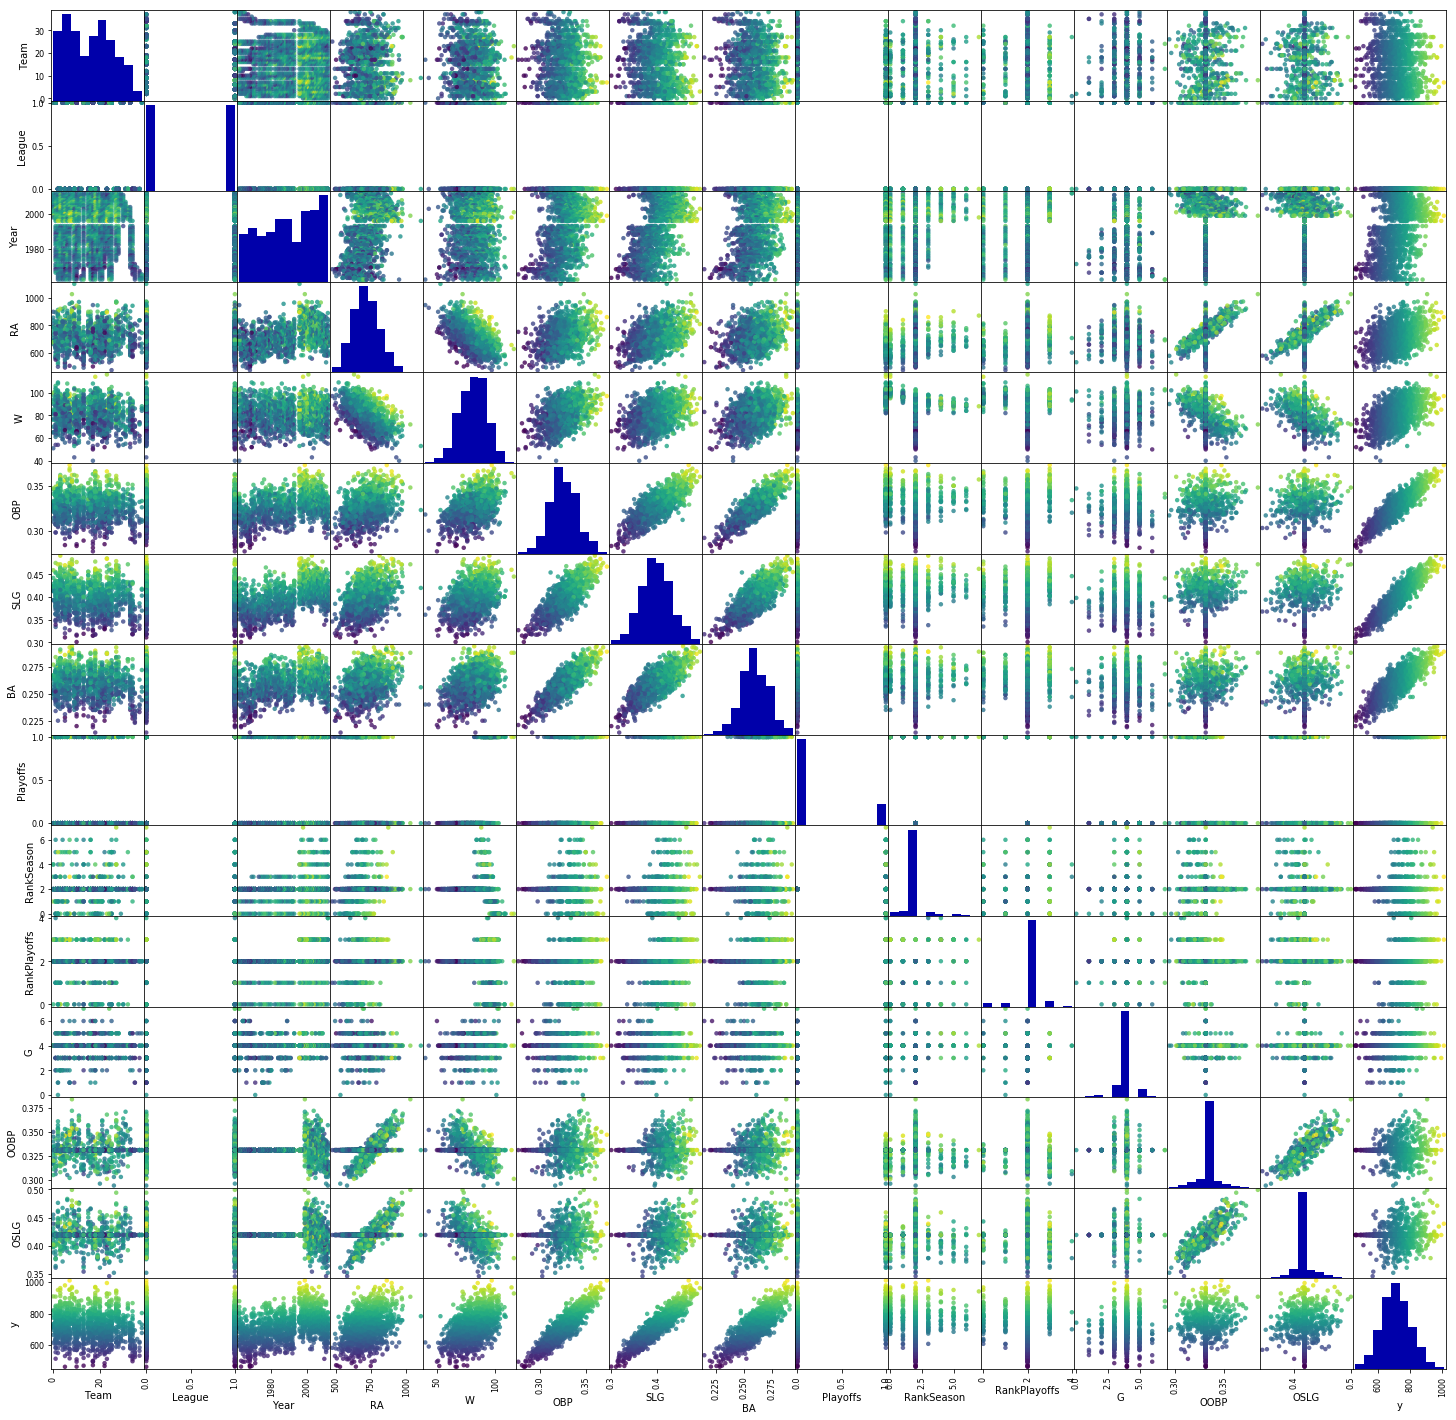

In [5]:
# Scatter matrix of dataframe including the target feature
copyframe = ballframe_clean.copy() 
copyframe['y'] = pd.Series(y, index=copyframe.index)
pd.scatter_matrix(copyframe, c=y, figsize=(25,25), 
                  marker='o', s=20, alpha=.8, cmap='viridis');

Several things immediately stand out:
* OBP, SLG and BA strongly correlate with the target (near-diagonals in the final column), but also combinations of either of these and W or R seem useful.
* RA, W, OBP, SLG and B seem normally distributed, most others do not. 
* OOBP and OSLG have a very peaked distribution. 
* Several features (e.g. League, Playoffs,...) are clearly categorical and should be encoded before doing linear regression. 

## Training linear regression models

To adequately build models, we need to:
- Impute missing values, e.g. by replacing NaN's with the feature median 
- Encode categorical features, e.g. using OneHotEncoding

We build a pipeline that does all these things in one go. We also explore the effect of scaling the data.

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Helper function to build and evaluate the pipelines
# Using MinMaxScaler because OneHotEncoding trips over negatively scaled values
# Another workaround would be panda's get_dummies method.
def evaluate(regressor, scaling=False):
    pipe = Pipeline([("imp", Imputer(strategy='median')), 
                     ("encoder", OneHotEncoder(categorical_features=categorical, handle_unknown='ignore')),
                     ("reg", regressor)])
    if scaling:
        pipe.steps.insert(1,["scaler", MinMaxScaler()]) 
    scores = cross_val_score(pipe, X, y)
    print("Cross-validated R^2 score for {}: {:.2f}".format(regressor.__class__.__name__, scores.mean()))
    
print("Without scaler:")
evaluate(LinearRegression())
evaluate(Ridge())
evaluate(Lasso())
evaluate(ElasticNet())

print("With scaler:")
evaluate(LinearRegression(), scaling=True)
evaluate(Ridge(), scaling=True)
evaluate(Lasso(), scaling=True)
evaluate(ElasticNet(), scaling=True)

Without scaler:
Cross-validated R^2 score for LinearRegression: 0.85
Cross-validated R^2 score for Ridge: 0.76
Cross-validated R^2 score for Lasso: 0.83
Cross-validated R^2 score for ElasticNet: 0.83
With scaler:
Cross-validated R^2 score for LinearRegression: 0.91
Cross-validated R^2 score for Ridge: 0.83
Cross-validated R^2 score for Lasso: 0.90
Cross-validated R^2 score for ElasticNet: 0.05


Interestingly, LinearRegression is better than Ridge, and slightly better than Lasso. The latter two are perhaps overfitting and need to be tuned.

Scaling helps performance significantly, except for ElasticNet. Since scaling also changes the scale of the coefficients, the default hyperparameter settings may just fit better after scaling. Indeed, if one feature had a very different scale, the corresponding coefficient has to compensate for this, leading to possibly large coefficients and more likely overfitting. Thus, scaling may sometimes act as a regularizer. It is less clear why ElasticSearch performs so much worse, we should check what happens if we tune it.

## Hyperparameter tuning
Next, we visualize the effect of the alpha regularizer for Ridge and Lasso, and both alpha and L1_ratio for ElasticNet

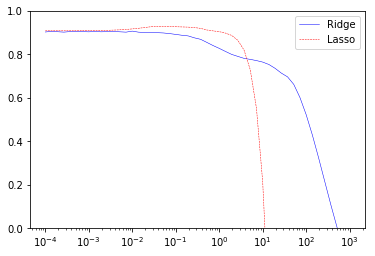

Best result 0.926 with {'reg__alpha': 0.071968567300115138}


In [7]:
from sklearn.model_selection import GridSearchCV 

grid_alpha = {'reg__alpha': np.logspace(-4, 3, num=50)}

# Build a pipeline and runs a grid search
def evaluateGrid(regressor, grid, scaling=True):
    pipe = Pipeline([("imp", Imputer(strategy='median')), 
                     ("encoder", OneHotEncoder(categorical_features=categorical, handle_unknown='ignore')),
                     ("reg", regressor)])
    if scaling:
        pipe.steps.insert(1,["scaler", MinMaxScaler()]) 
    return GridSearchCV(pipe, grid).fit(X, y)

ridge_res = evaluateGrid(Ridge(), grid_alpha)
_=plt.plot([d['reg__alpha'] for d in ridge_res.cv_results_['params']], 
           ridge_res.cv_results_['mean_test_score'], 'b', label='Ridge')
lasso_res = evaluateGrid(Lasso(), grid_alpha)
_=plt.plot([d['reg__alpha'] for d in lasso_res.cv_results_['params']], 
           lasso_res.cv_results_['mean_test_score'], 'r', label='Lasso')
_=plt.xscale('log')
_=plt.ylim([0.001, 1])
plt.legend()
plt.show();
print("Best result {:.3f} with {}".format(lasso_res.best_score_, lasso_res.best_params_));

Lasso (red line) find a better model than Ridge, with an optional alpha of around 0.1. For values larger than 1, it starts underfitting heavily (it penalizes large coefficients too much), and $R^2$ drops to 0 (and lower). Ridge performs worse than Lasso overall, but is less sensitive to alpha and only starts overfitting heavily for alpha values of 100 or larger.

Next, we tune ElasticNet.

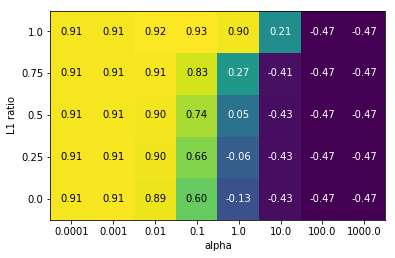

In [56]:
# Run a 2D grid search and build a heatmap with the results
grid_elastic_net = {'reg__alpha': np.logspace(-4, 3, num=8),
                    'reg__l1_ratio': np.linspace(0, 1, num=5)}
en_res = evaluateGrid(ElasticNet(), grid_elastic_net)

# Reshape and transpose (we want alpha on the x-axes to compare with the previous plot)
scores = en_res.cv_results_['mean_test_score'].reshape(grid_elastic_net['reg__alpha'].size,
                                                       grid_elastic_net['reg__l1_ratio'].size).T
mglearn.tools.heatmap(scores, xlabel='alpha', xticklabels=grid_elastic_net['reg__alpha'],
                      ylabel='L1 ratio', yticklabels=grid_elastic_net['reg__l1_ratio'], cmap="viridis");

For ElasticNet, the alpha hyperparameter clearly has the biggest impact on the accuracy. Similar to the previous plot, very small alpha values lesd to very slight overfitting, and very large values to disastrous underfitting. For alpha=0.1 and 1 we see a clear gradient favouring L1 loss: the lower the L1 ratio, the lower the performance. 

We also see our previous findings confirmed:
- the best results are obtained by L1_ratio=1 (equal to Lasso) and alpha around 0.1 (see the previous curve)
- the default ElasticNet (alpha=1,L1_ration=0.5) with standardisation performs badly, with $R^2=0.05$ (see the previous table)

In [9]:
print("Best configuration:",en_res.best_params_)

Best configuration: {'reg__alpha': 0.10000000000000001, 'reg__l1_ratio': 1.0}


Out of curiosity, let's now switch off the scaling. We get a similar heatmap, but 'streched' around alpha=0.1. The results of the 'scaled' alpha=0.01 are now (approximately) seen for alpha=0.0001 and the results of the 'scaled' alpha=0.1 are now seen around alpha=100. Hence, scaling made the models much more sensitive to alpha value.

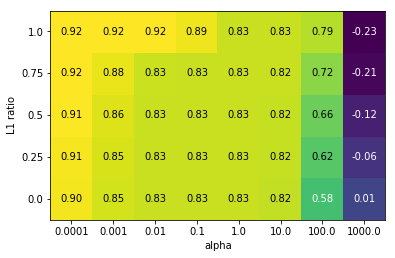

In [10]:
en_res2 = evaluateGrid(ElasticNet(), grid_elastic_net, scaling=False)

# Reshape and transpose (we want alpha on the x-axes to compare with the previous plot)
scores = en_res2.cv_results_['mean_test_score'].reshape(grid_elastic_net['reg__alpha'].size,
                                                grid_elastic_net['reg__l1_ratio'].size).T
mglearn.tools.heatmap(scores, xlabel='alpha', xticklabels=grid_elastic_net['reg__alpha'],
                      ylabel='L1 ratio', yticklabels=grid_elastic_net['reg__l1_ratio'], cmap="viridis");

## Visualizing the coefficients 
Do the different models agree on which features are important? We also compare the results with the feature importances returned by a RandomForest.

In [11]:
# The OneHotEncoder has messed up our attribute names, so we must map features to names again
# feature_indices_ returns a mapping for the one-hot-encoded features
fi = lasso_res.best_estimator_.get_params()['encoder'].feature_indices_
encoded_feats = np.array(attribute_names)[np.array(categorical)]
non_encoded_feats = np.array(attribute_names)[~np.array(categorical)]
new_names = []
for i, name in enumerate(encoded_feats):
    for j in range(fi[i+1]-fi[i]):
        new_names.append("{}_{}".format(name,j))
new_names.extend(non_encoded_feats)

In [22]:
# We additionally train a RandomForest to see if it returns the same feature importances
from sklearn.ensemble import RandomForestRegressor
rf_pipe = Pipeline([("imp", Imputer(strategy='median')),
                 ("scaler", MinMaxScaler()), #Adding scaler so that the OHE behaves the same
                 ("encoder", OneHotEncoder(categorical_features=categorical, handle_unknown='ignore')),
                 ("reg", RandomForestRegressor(n_estimators=100))])
rf_pipe.fit(X, y);

In [32]:
max(rf_pipe.named_steps.reg.feature_importances_)

0.75230929412401049

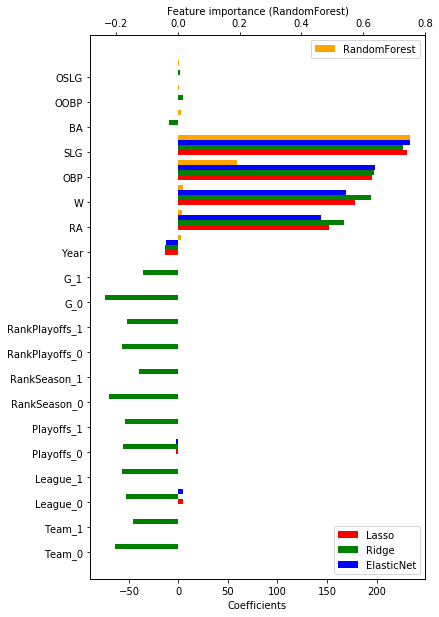

In [47]:
df = pd.DataFrame({'names': new_names, 
                   'lasso': lasso_res.best_estimator_.get_params()['reg'].coef_,
                   'ridge': ridge_res.best_estimator_.get_params()['reg'].coef_,
                   'elastic_net': en_res.best_estimator_.get_params()['reg'].coef_,
                   'random_forest': rf_pipe.named_steps.reg.feature_importances_})
ind = np.arange(len(df))
width = 0.2

# Coefficients
fig, ax = plt.subplots(figsize=(6, 10))
ax.barh(ind, df.lasso, width, color='red', label='Lasso')
ax.barh(ind + width, df.ridge, width, color='green', label='Ridge')
ax.barh(ind + width*2, df.elastic_net, width, color='blue', label='ElasticNet')
ax.set_yticklabels(new_names)
ax.set_yticks(np.arange(len(new_names)))
ax.set_xlabel('Coefficients')

# RandomForest feature importances
ax2 = ax.twiny()
ax2.barh(ind + width*3, df.random_forest, width, color='orange', label='RandomForest')
ax2.set_xlabel('Feature importance (RandomForest)')
ax2.set_xlim(-0.285, 0.8) #
ax.legend(loc='lower right')
ax2.legend()
plt.show()

The optimal models for elasticNet, ridge and lasso roughly agree on the importance of features. Especially SLG, OBP, W, and RA are deemed important, and to a lesser degree Year. OSLG, OOBP, and BA are deemed largely important.

One very obvious phenomenon is that Ridge considers all the one-hot-encoded features to be quite important. Since ridge uses the L2 norm, it will prefer many small coefficients, whereas Lasso (L1 norm) prefers to have many coefficients equal to 0. This is exactly what we are seeing here. From the plots above, we've seen that Ridge performs worse than Lasso, and the rather large coefficients for one-hot-encoded features hint at overfitting.

The optimal elasticnet had an L1_ratio=1, and will thus behave almost identical to Lasso.

RandomForest gives more or less similar results, although it deems W and RA much less important.

In [ ]:
We can also estimate feature importance with a RandomForest